<a href="https://colab.research.google.com/github/IzmailovRuslan/super-duper-giggle/blob/main/Fine_Tuning_(simpsons_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>
<h3 style="text-align: center;"><b>FineTuning</b></h3>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

Задача - научить предобученный классификатор распознавать персонажа из сериала "Симпсоны"

# Подготовка 

In [ ]:
!pip install torchvision

In [ ]:
from os.path import exists
import torch

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0

In [ ]:
# Подключает к ноутбуку наш диск гугл-драйв
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Выясняем, как называется наш корневой каталог
!ls /content/gdrive/

MyDrive


In [ ]:
# Убедимся, что ранее загруженный архив виден
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Apr  8 16:21 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
# Распаковываем архив
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
# Посмотрим, что в дерикториях
!ls train
!ls testset

simpsons_dataset
testset


In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 для alexnet, 227x227 для inception 
RESCALE_SIZE = 227                                           
# работаем на видеокарте
DEVICE = torch.device("cuda")

Используем враппер над датасетом для удобной работы

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок,
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # Список файлов для загрузки
        self.files = sorted(files)
        # Режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files] # Для каждого файла получаем родительский каталог (его название - метка класса)
            self.label_encoder.fit(self.labels)  # Обучаем encoder

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)  # Открывает и идентифицирует файл изображения
        image.load()  # Выделяет память для изображения и загружает данные пикселей в память 
        return image
      
    def _prepare_sample(self, image):   # Переводим картину в размер 224х224
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
  
    def __getitem__(self, index):
        # Для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')  # Нормализация на входе 
        x = transform(x)
        if self.mode == 'test':
            return x   # Для теста возвращаем только картинку 
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y  # Для трейна - кратинку и метку 
        
    

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')  # Дериктория с трейном
TEST_DIR = Path('testset/testset')          # Дериктория с тестом

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))  # Отсортированные по алфавиту пути ко всем найденым файлам
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # Для каждого файла получаем родительский каталог (его название - метка класса)
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

# Функции обучения / валидации

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), '/content/state.pth')
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    # загрузим лучшие веса модели
    model.load_state_dict(torch.load('/content/state.pth'))
    return model, history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Попробуем воспользоваться предобученной сеткой AlexNet

In [ ]:
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

#Попробуем Fine Tuning

In [ ]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# Смотрим что внутри
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000, out_features=42, bias=True)
  )
# Использовать ли GPU
if train_on_gpu:
     model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)

# Умножает learning_rate на 0.1 каждые 8 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

In [ ]:
model, history = train(train_dataset, val_dataset, model, epochs=7, batch_size=256)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.15860781848764743


epoch:  14%|█▍        | 1/7 [03:24<20:26, 204.35s/it]


Epoch 001 train_loss: 0.1586     val_loss 0.9523 train_acc 0.9638 val_acc 0.8651
loss 0.14671180696785546


epoch:  29%|██▊       | 2/7 [06:43<16:46, 201.38s/it]


Epoch 002 train_loss: 0.1467     val_loss 0.6888 train_acc 0.9671 val_acc 0.8854
loss 0.09591066445252402


epoch:  43%|████▎     | 3/7 [10:05<13:25, 201.46s/it]


Epoch 003 train_loss: 0.0959     val_loss 0.7517 train_acc 0.9772 val_acc 0.8896
loss 0.10786699761125007


epoch:  57%|█████▋    | 4/7 [13:25<10:03, 201.15s/it]


Epoch 004 train_loss: 0.1079     val_loss 0.6581 train_acc 0.9742 val_acc 0.8957
loss 0.11037520672068835


epoch:  71%|███████▏  | 5/7 [16:39<06:36, 198.40s/it]


Epoch 005 train_loss: 0.1104     val_loss 0.7357 train_acc 0.9727 val_acc 0.8888
loss 0.11764947298746427


epoch:  86%|████████▌ | 6/7 [19:46<03:14, 194.48s/it]


Epoch 006 train_loss: 0.1176     val_loss 0.6443 train_acc 0.9727 val_acc 0.8886
loss 0.10257185843330453


epoch: 100%|██████████| 7/7 [22:54<00:00, 196.43s/it]


Epoch 007 train_loss: 0.1026     val_loss 0.7328 train_acc 0.9769 val_acc 0.8915


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

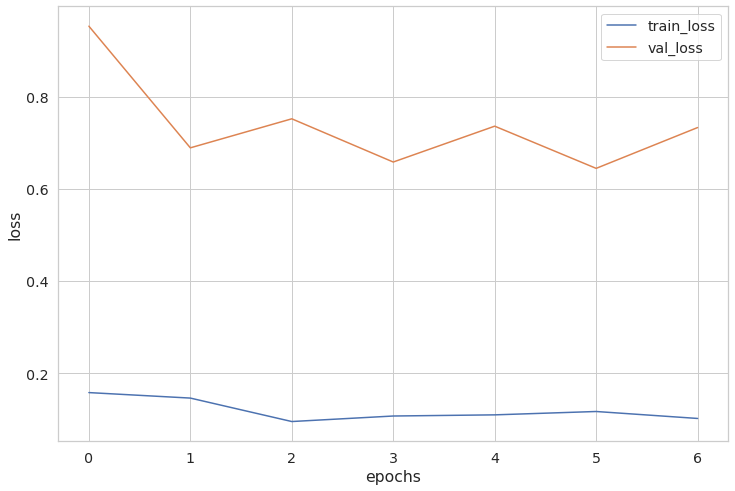

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

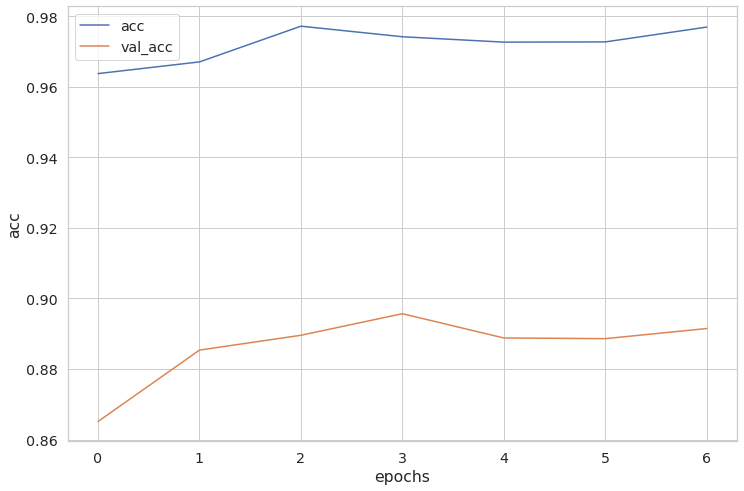

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(acc, label="acc")
plt.plot(torch.Tensor(val_acc).to('cpu'), label="val_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [ ]:
# Сохраним лучшую модель
torch.save(model.state_dict(), 'AlexNet_FT_konechnoe.pth')

In [ ]:
model.load_state_dict(torch.load('AlexNet_FT_konechnoe.pth'))

<All keys matched successfully>

KAGGLE Score: 0.96705

Ссылка на соревнование: https://www.kaggle.com/competitions/journey-springfield

#Пробуем Feature Extractor

In [ ]:
model_extractor = models.alexnet(pretrained=True)

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000, out_features=42, bias=True)
  )
# Использовать ли GPU
if train_on_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-3)

# Умножает learning_rate на 0.1 каждые 10 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_extr, history = train(train_dataset, val_dataset, model_extractor, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.6382361343540397


epoch:   5%|▌         | 1/20 [02:52<54:34, 172.33s/it]


Epoch 001 train_loss: 1.6382     val_loss 1.1669 train_acc 0.5604 val_acc 0.7014
loss 1.2821368152103998


epoch:  10%|█         | 2/20 [05:35<50:08, 167.13s/it]


Epoch 002 train_loss: 1.2821     val_loss 1.0293 train_acc 0.6537 val_acc 0.7356
loss 1.14186880412212


epoch:  15%|█▌        | 3/20 [08:17<46:37, 164.58s/it]


Epoch 003 train_loss: 1.1419     val_loss 0.9164 train_acc 0.6842 val_acc 0.7604
loss 1.0497418527459177


epoch:  20%|██        | 4/20 [10:59<43:38, 163.69s/it]


Epoch 004 train_loss: 1.0497     val_loss 0.9128 train_acc 0.7041 val_acc 0.7650
loss 1.0001819792033169


epoch:  25%|██▌       | 5/20 [13:40<40:42, 162.81s/it]


Epoch 005 train_loss: 1.0002     val_loss 0.8362 train_acc 0.7169 val_acc 0.7875
loss 0.9243659556530882


epoch:  30%|███       | 6/20 [16:23<37:57, 162.64s/it]


Epoch 006 train_loss: 0.9244     val_loss 0.8154 train_acc 0.7381 val_acc 0.7902
loss 0.8806226208252667


epoch:  35%|███▌      | 7/20 [19:08<35:23, 163.33s/it]


Epoch 007 train_loss: 0.8806     val_loss 0.8116 train_acc 0.7460 val_acc 0.7973
loss 0.8437307676286999


epoch:  40%|████      | 8/20 [21:52<32:44, 163.70s/it]


Epoch 008 train_loss: 0.8437     val_loss 0.7888 train_acc 0.7554 val_acc 0.7998
loss 0.8178696805553471


epoch:  45%|████▌     | 9/20 [24:33<29:50, 162.79s/it]


Epoch 009 train_loss: 0.8179     val_loss 0.7768 train_acc 0.7594 val_acc 0.7979
loss 0.7961045506881509


epoch:  50%|█████     | 10/20 [27:16<27:08, 162.87s/it]


Epoch 010 train_loss: 0.7961     val_loss 0.7735 train_acc 0.7697 val_acc 0.8007
loss 0.7671259488260012


epoch:  55%|█████▌    | 11/20 [29:58<24:25, 162.79s/it]


Epoch 011 train_loss: 0.7671     val_loss 0.7463 train_acc 0.7754 val_acc 0.8070
loss 0.7425084545951154


epoch:  60%|██████    | 12/20 [32:40<21:39, 162.41s/it]


Epoch 012 train_loss: 0.7425     val_loss 0.7297 train_acc 0.7810 val_acc 0.8089
loss 0.700560368104409


epoch:  65%|██████▌   | 13/20 [35:22<18:55, 162.23s/it]


Epoch 013 train_loss: 0.7006     val_loss 0.7375 train_acc 0.7940 val_acc 0.8082
loss 0.7046954923696948


epoch:  70%|███████   | 14/20 [38:04<16:13, 162.18s/it]


Epoch 014 train_loss: 0.7047     val_loss 0.7479 train_acc 0.7931 val_acc 0.8126
loss 0.7087856693756536


epoch:  75%|███████▌  | 15/20 [40:46<13:31, 162.28s/it]


Epoch 015 train_loss: 0.7088     val_loss 0.7254 train_acc 0.7916 val_acc 0.8091
loss 0.6725570403912225


epoch:  80%|████████  | 16/20 [43:30<10:51, 162.81s/it]


Epoch 016 train_loss: 0.6726     val_loss 0.7183 train_acc 0.7976 val_acc 0.8143
loss 0.6691409583091432


epoch:  85%|████████▌ | 17/20 [46:11<08:06, 162.28s/it]


Epoch 017 train_loss: 0.6691     val_loss 0.7224 train_acc 0.8010 val_acc 0.8118
loss 0.6572863862456634


epoch:  90%|█████████ | 18/20 [48:55<05:25, 162.77s/it]


Epoch 018 train_loss: 0.6573     val_loss 0.7132 train_acc 0.8068 val_acc 0.8196
loss 0.6530095186762934


epoch:  95%|█████████▌| 19/20 [51:40<02:43, 163.40s/it]


Epoch 019 train_loss: 0.6530     val_loss 0.6927 train_acc 0.8071 val_acc 0.8223
loss 0.6301434617474152


epoch: 100%|██████████| 20/20 [54:22<00:00, 163.12s/it]


Epoch 020 train_loss: 0.6301     val_loss 0.7193 train_acc 0.8136 val_acc 0.8145


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

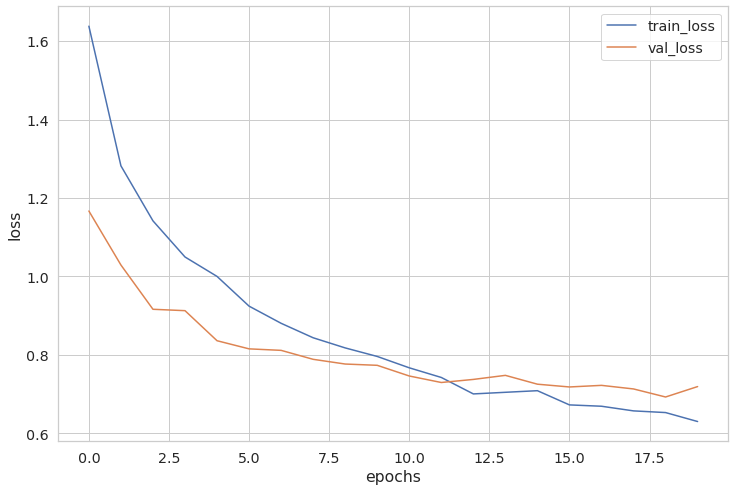

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

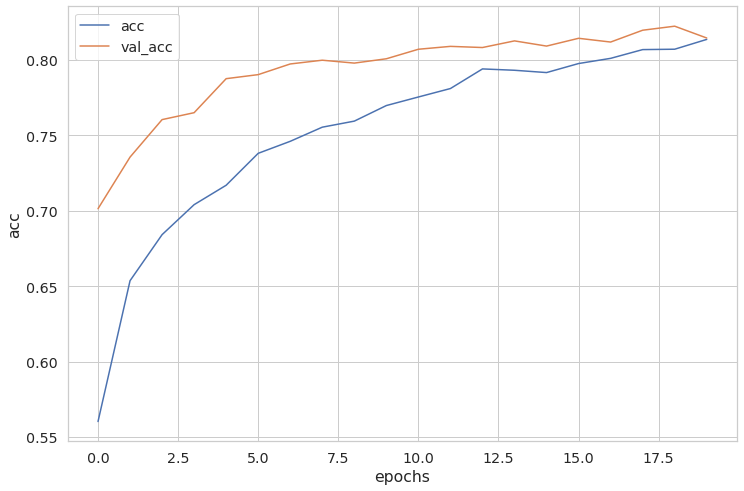

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(acc, label="acc")
plt.plot(torch.Tensor(val_acc).to('cpu'), label="val_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'AlexNet_FE.pth')
model.load_state_dict(torch.load('AlexNet_FE.pth'))

<All keys matched successfully>

В этой модели классификатор сделан более богатым для того, чтобы сеть могла лучше интерпретировать выходы слоев, которые вообще не обучаются. В любом случае, даже с упрощенным классификатором, такая модель сходится очень долго (и я уверен, что не сойдется до результатов Fine-Tune модели). По этой причине от такого подхода отказываюсь.

#Пробуем слабее обучать свертки

In [ ]:
model_diff_lr = models.alexnet(pretrained=True)

In [ ]:
# Заменяем Fully-Connected слой на наш линейный классификатор
model_diff_lr.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000, out_features=42, bias=True)
  )

# Использовать ли GPU
if train_on_gpu:
    model_diff_lr = model_diff_lr.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем классификатор и слабо переобучаем свертки
optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-4,}
    ], 
    lr=1e-3
)

# Умножает learning_rate на 0.1 каждые 10 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_diff_lr_best, history = train(train_dataset, val_dataset, model_diff_lr, epochs=30, batch_size=128)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 2.764180301002533


epoch:   3%|▎         | 1/30 [02:23<1:09:26, 143.68s/it]


Epoch 001 train_loss: 2.7642     val_loss 1.9849 train_acc 0.2280 val_acc 0.4314
loss 1.5460397698589325


epoch:   7%|▋         | 2/30 [04:42<1:05:46, 140.94s/it]


Epoch 002 train_loss: 1.5460     val_loss 1.2066 train_acc 0.5709 val_acc 0.6798
loss 0.977793678507485


epoch:  10%|█         | 3/30 [07:04<1:03:38, 141.43s/it]


Epoch 003 train_loss: 0.9778     val_loss 0.8407 train_acc 0.7327 val_acc 0.7822
loss 0.7250989443238764


epoch:  13%|█▎        | 4/30 [09:32<1:02:20, 143.88s/it]


Epoch 004 train_loss: 0.7251     val_loss 0.7128 train_acc 0.8005 val_acc 0.8191
loss 0.5515475868495363


epoch:  17%|█▋        | 5/30 [11:53<59:32, 142.89s/it]


Epoch 005 train_loss: 0.5515     val_loss 0.6788 train_acc 0.8492 val_acc 0.8284
loss 0.44996804911677674


epoch:  20%|██        | 6/30 [14:14<56:55, 142.30s/it]


Epoch 006 train_loss: 0.4500     val_loss 0.5752 train_acc 0.8762 val_acc 0.8628
loss 0.35098569561086707


epoch:  23%|██▎       | 7/30 [16:35<54:19, 141.71s/it]


Epoch 007 train_loss: 0.3510     val_loss 0.5779 train_acc 0.9001 val_acc 0.8640
loss 0.32350873015239606


epoch:  27%|██▋       | 8/30 [18:53<51:33, 140.60s/it]


Epoch 008 train_loss: 0.3235     val_loss 0.6424 train_acc 0.9086 val_acc 0.8567
loss 0.26476520729699754


epoch:  30%|███       | 9/30 [21:11<48:56, 139.85s/it]


Epoch 009 train_loss: 0.2648     val_loss 0.6450 train_acc 0.9229 val_acc 0.8615
loss 0.25666893839729815


epoch:  33%|███▎      | 10/30 [23:32<46:45, 140.26s/it]


Epoch 010 train_loss: 0.2567     val_loss 0.5716 train_acc 0.9281 val_acc 0.8825
loss 0.20279196976924355


epoch:  37%|███▋      | 11/30 [25:54<44:35, 140.83s/it]


Epoch 011 train_loss: 0.2028     val_loss 0.5549 train_acc 0.9414 val_acc 0.8812
loss 0.23503930935818523


epoch:  40%|████      | 12/30 [28:15<42:14, 140.80s/it]


Epoch 012 train_loss: 0.2350     val_loss 0.6825 train_acc 0.9350 val_acc 0.8697
loss 0.25166009676229406


epoch:  43%|████▎     | 13/30 [30:34<39:45, 140.35s/it]


Epoch 013 train_loss: 0.2517     val_loss 0.5854 train_acc 0.9310 val_acc 0.8708
loss 0.25391563025581826


epoch:  47%|████▋     | 14/30 [32:53<37:17, 139.82s/it]


Epoch 014 train_loss: 0.2539     val_loss 0.6225 train_acc 0.9310 val_acc 0.8678
loss 0.19222588869988352


epoch:  50%|█████     | 15/30 [35:12<34:53, 139.59s/it]


Epoch 015 train_loss: 0.1922     val_loss 0.6302 train_acc 0.9476 val_acc 0.8842
loss 0.2021083631614749


epoch:  53%|█████▎    | 16/30 [37:30<32:28, 139.16s/it]


Epoch 016 train_loss: 0.2021     val_loss 0.7408 train_acc 0.9460 val_acc 0.8808
loss 0.21272166936031092


epoch:  57%|█████▋    | 17/30 [39:48<30:03, 138.71s/it]


Epoch 017 train_loss: 0.2127     val_loss 0.7677 train_acc 0.9428 val_acc 0.8655
loss 0.15358800081620058


epoch:  60%|██████    | 18/30 [42:06<27:44, 138.67s/it]


Epoch 018 train_loss: 0.1536     val_loss 0.6951 train_acc 0.9586 val_acc 0.8812
loss 0.16149245061873022


epoch:  63%|██████▎   | 19/30 [44:24<25:21, 138.28s/it]


Epoch 019 train_loss: 0.1615     val_loss 0.7157 train_acc 0.9565 val_acc 0.8756
loss 0.17808753840520403


epoch:  67%|██████▋   | 20/30 [46:41<23:00, 138.07s/it]


Epoch 020 train_loss: 0.1781     val_loss 0.8071 train_acc 0.9543 val_acc 0.8550
loss 0.291661360227338


epoch:  70%|███████   | 21/30 [48:59<20:40, 137.89s/it]


Epoch 021 train_loss: 0.2917     val_loss 0.7993 train_acc 0.9288 val_acc 0.8621
loss 0.2233787560112325


epoch:  73%|███████▎  | 22/30 [51:20<18:31, 138.94s/it]


Epoch 022 train_loss: 0.2234     val_loss 0.7760 train_acc 0.9452 val_acc 0.8651
loss 0.15635567379998996


epoch:  77%|███████▋  | 23/30 [53:38<16:10, 138.68s/it]


Epoch 023 train_loss: 0.1564     val_loss 0.8095 train_acc 0.9586 val_acc 0.8777
loss 0.14699617493144265


epoch:  80%|████████  | 24/30 [55:56<13:50, 138.37s/it]


Epoch 024 train_loss: 0.1470     val_loss 0.7156 train_acc 0.9629 val_acc 0.8770
loss 0.1432612415077322


epoch:  83%|████████▎ | 25/30 [58:14<11:30, 138.12s/it]


Epoch 025 train_loss: 0.1433     val_loss 0.7720 train_acc 0.9620 val_acc 0.8869
loss 0.16286406292680858


epoch:  87%|████████▋ | 26/30 [1:00:31<09:11, 137.98s/it]


Epoch 026 train_loss: 0.1629     val_loss 0.8457 train_acc 0.9613 val_acc 0.8768
loss 0.220243017712143


epoch:  90%|█████████ | 27/30 [1:02:49<06:54, 138.03s/it]


Epoch 027 train_loss: 0.2202     val_loss 0.7695 train_acc 0.9497 val_acc 0.8779
loss 0.17497722881429856


epoch:  93%|█████████▎| 28/30 [1:05:07<04:36, 138.00s/it]


Epoch 028 train_loss: 0.1750     val_loss 0.7406 train_acc 0.9569 val_acc 0.8934
loss 0.16728872255737123


epoch:  97%|█████████▋| 29/30 [1:07:26<02:18, 138.07s/it]


Epoch 029 train_loss: 0.1673     val_loss 0.9159 train_acc 0.9634 val_acc 0.8615
loss 0.16888351206794022


epoch: 100%|██████████| 30/30 [1:09:43<00:00, 139.46s/it]


Epoch 030 train_loss: 0.1689     val_loss 0.7670 train_acc 0.9596 val_acc 0.8779


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

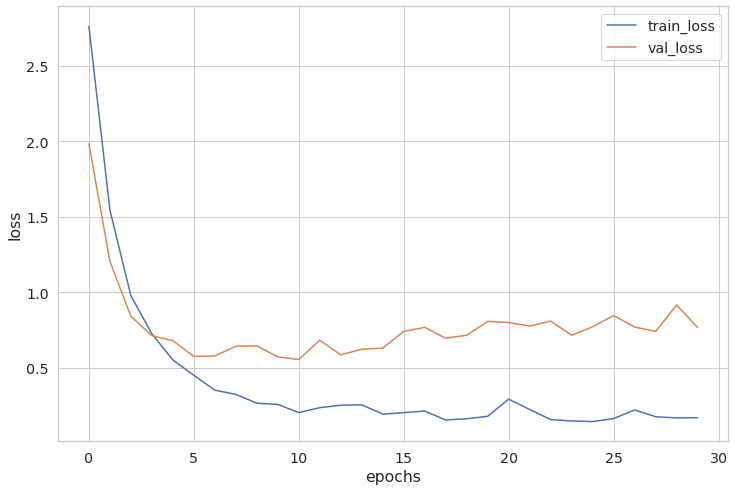

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

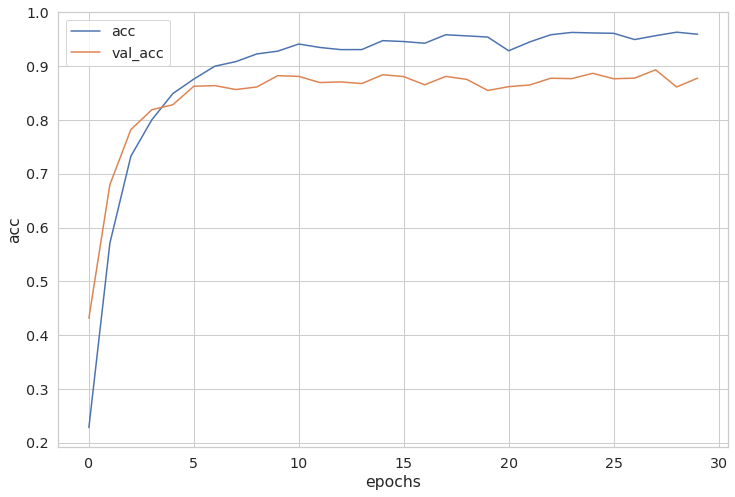

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(acc, label="acc")
plt.plot(torch.Tensor(val_acc).to('cpu'), label="val_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [ ]:
torch.save(model_diff_lr_best.state_dict(), 'alexnet_diff_lr.pth')
model_diff_lr_best.load_state_dict(torch.load('alexnet_diff_lr.pth'))

<All keys matched successfully>

KAGGLE Score: 0.95642

# Попробуем обучить ResNet методом Fine-Tune 

In [ ]:
model_ResNet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ResNet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_ResNet.fc = nn.Linear(in_features=512, out_features=42, bias=True)
# Использовать ли GPU
if train_on_gpu:
     model_ResNet = model_ResNet.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем классификатор и слабо переобучаем свертки
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=1e-3)

# Умножает learning_rate на 0.1 каждые 4 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [ ]:
model_inception_best, history = train(train_dataset, val_dataset, model_ResNet, epochs=25, batch_size=256)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.6618067010419901


epoch:   4%|▍         | 1/25 [04:50<1:56:03, 290.13s/it]


Epoch 001 train_loss: 0.6618     val_loss 0.7193 train_acc 0.8473 val_acc 0.8080
loss 0.16428505607802166


epoch:   8%|▊         | 2/25 [09:35<1:50:07, 287.28s/it]


Epoch 002 train_loss: 0.1643     val_loss 0.4574 train_acc 0.9610 val_acc 0.8749
loss 0.06100307774652728


epoch:  12%|█▏        | 3/25 [14:09<1:43:11, 281.43s/it]


Epoch 003 train_loss: 0.0610     val_loss 0.2520 train_acc 0.9864 val_acc 0.9394
loss 0.028912278461739344


epoch:  16%|█▌        | 4/25 [18:42<1:37:15, 277.88s/it]


Epoch 004 train_loss: 0.0289     val_loss 0.2844 train_acc 0.9929 val_acc 0.9291
loss 0.020739285505160045


epoch:  20%|██        | 5/25 [23:23<1:33:03, 279.15s/it]


Epoch 005 train_loss: 0.0207     val_loss 0.2255 train_acc 0.9950 val_acc 0.9503
loss 0.02061508659775739


epoch:  24%|██▍       | 6/25 [28:01<1:28:14, 278.63s/it]


Epoch 006 train_loss: 0.0206     val_loss 0.3057 train_acc 0.9948 val_acc 0.9251
loss 0.023280767405824347


epoch:  28%|██▊       | 7/25 [32:38<1:23:27, 278.19s/it]


Epoch 007 train_loss: 0.0233     val_loss 0.3519 train_acc 0.9942 val_acc 0.9119
loss 0.039936346733562125


epoch:  32%|███▏      | 8/25 [37:17<1:18:51, 278.33s/it]


Epoch 008 train_loss: 0.0399     val_loss 0.5286 train_acc 0.9880 val_acc 0.8705
loss 0.051807654158625906


epoch:  36%|███▌      | 9/25 [41:56<1:14:16, 278.54s/it]


Epoch 009 train_loss: 0.0518     val_loss 0.5473 train_acc 0.9850 val_acc 0.8699
loss 0.0398218749752251


epoch:  40%|████      | 10/25 [46:43<1:10:17, 281.16s/it]


Epoch 010 train_loss: 0.0398     val_loss 0.2723 train_acc 0.9885 val_acc 0.9350
loss 0.014955009882533461


epoch:  44%|████▍     | 11/25 [51:29<1:05:56, 282.59s/it]


Epoch 011 train_loss: 0.0150     val_loss 0.2626 train_acc 0.9954 val_acc 0.9410
loss 0.013414430327078014


epoch:  48%|████▊     | 12/25 [56:12<1:01:18, 282.97s/it]


Epoch 012 train_loss: 0.0134     val_loss 0.2539 train_acc 0.9963 val_acc 0.9427
loss 0.007855852505743752


epoch:  52%|█████▏    | 13/25 [1:00:56<56:38, 283.19s/it]


Epoch 013 train_loss: 0.0079     val_loss 0.2650 train_acc 0.9980 val_acc 0.9396
loss 0.006197251069167688


epoch:  56%|█████▌    | 14/25 [1:05:31<51:27, 280.65s/it]


Epoch 014 train_loss: 0.0062     val_loss 0.2585 train_acc 0.9984 val_acc 0.9402
loss 0.006091821081881782


epoch:  60%|██████    | 15/25 [1:10:07<46:31, 279.14s/it]


Epoch 015 train_loss: 0.0061     val_loss 0.2062 train_acc 0.9983 val_acc 0.9538
loss 0.004924081202887527


epoch:  64%|██████▍   | 16/25 [1:14:45<41:51, 279.03s/it]


Epoch 016 train_loss: 0.0049     val_loss 0.2157 train_acc 0.9989 val_acc 0.9515
loss 0.004032146566435272


epoch:  68%|██████▊   | 17/25 [1:19:23<37:07, 278.49s/it]


Epoch 017 train_loss: 0.0040     val_loss 0.2556 train_acc 0.9990 val_acc 0.9499
loss 0.0036193959560776577


epoch:  72%|███████▏  | 18/25 [1:24:01<32:30, 278.61s/it]


Epoch 018 train_loss: 0.0036     val_loss 0.2370 train_acc 0.9992 val_acc 0.9496
loss 0.001820543439618883


epoch:  76%|███████▌  | 19/25 [1:28:46<28:01, 280.25s/it]


Epoch 019 train_loss: 0.0018     val_loss 0.2012 train_acc 0.9997 val_acc 0.9572
loss 0.002725087734955149


epoch:  80%|████████  | 20/25 [1:33:29<23:25, 281.19s/it]


Epoch 020 train_loss: 0.0027     val_loss 0.3045 train_acc 0.9992 val_acc 0.9364
loss 0.01746991585215306


epoch:  84%|████████▍ | 21/25 [1:38:08<18:42, 280.61s/it]


Epoch 021 train_loss: 0.0175     val_loss 1.1571 train_acc 0.9950 val_acc 0.7860
loss 0.0331524384887695


epoch:  88%|████████▊ | 22/25 [1:42:51<14:03, 281.14s/it]


Epoch 022 train_loss: 0.0332     val_loss 0.3979 train_acc 0.9899 val_acc 0.9050
loss 0.0290528189383067


epoch:  92%|█████████▏| 23/25 [1:47:40<09:27, 283.68s/it]


Epoch 023 train_loss: 0.0291     val_loss 0.2842 train_acc 0.9921 val_acc 0.9385
loss 0.022089675307099217


epoch:  96%|█████████▌| 24/25 [1:52:29<04:45, 285.17s/it]


Epoch 024 train_loss: 0.0221     val_loss 0.2516 train_acc 0.9943 val_acc 0.9413
loss 0.006915000297835892


epoch: 100%|██████████| 25/25 [1:57:12<00:00, 281.29s/it]


Epoch 025 train_loss: 0.0069     val_loss 0.1910 train_acc 0.9982 val_acc 0.9582


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

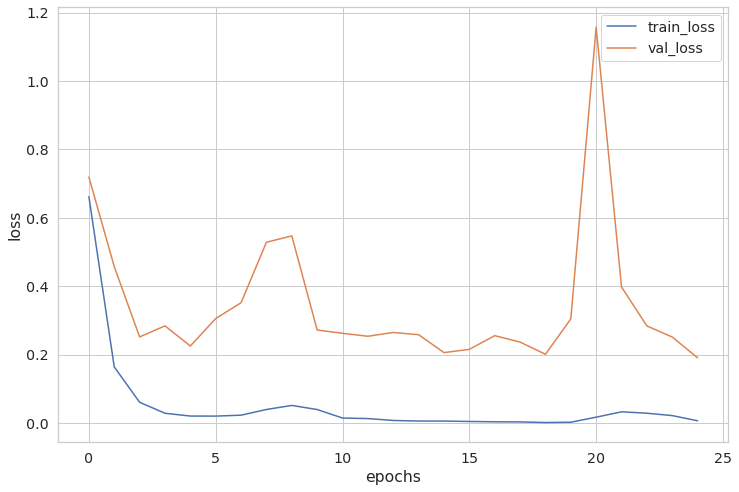

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

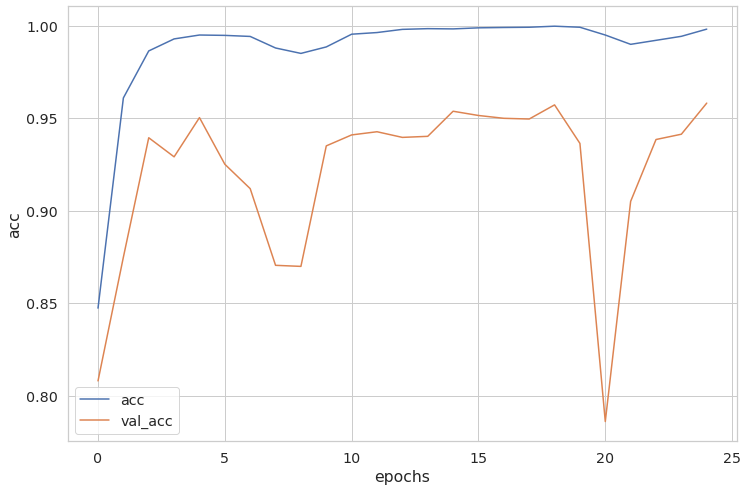

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(12, 8))
plt.plot(acc, label="acc")
plt.plot(torch.Tensor(val_acc).to('cpu'), label="val_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
running_loss, running_corrects, processed_size = 0, 0, 0
for inputs, labels in val_loader:
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')

        outputs = model_inception_best.to('cpu')(inputs)
        loss = loss_fn(outputs, labels)
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
val_loss = running_loss / processed_size
val_acc = running_corrects.double() / processed_size
print(val_loss, val_acc)

In [ ]:
torch.save(model_ResNet.state_dict(), 'ResNet_best.pth')
model_ResNet.load_state_dict(torch.load('ResNet_best.pth'))

<All keys matched successfully>

KAGGLE Score: 0.97555

Ожидаемо, что более богатая сеть решает задачу лучше, однако быстро переобучается и процесс обучения выглядит более нестабильным

Submit for KAGGLE

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb')) # Загружаем объект из файла

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ResNet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls 

AlexNet_FE.pth		       gdrive		      testset
AlexNet_FT_konechnoe.pth       label_encoder.pkl      train
alexnet_submission_FT_kon.csv  sample_data
characters_illustration.png    sample_submission.csv


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [ ]:
my_submit.to_csv('model_ResNet.csv', index=False)